In [18]:
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
#from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
#nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import cross_val_score

In [19]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [20]:
dataset=dataset.loc[:,['sentiment','text']]

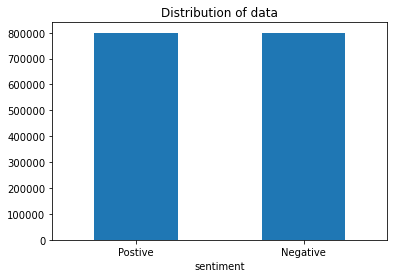

In [21]:
# Replacing the values to ease understanding.
# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Postive','Negative'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [22]:
dataset['sentiment'].value_counts()/dataset['sentiment'].shape[0]*100

4    50.0
0    50.0
Name: sentiment, dtype: float64

In [ ]:
dataset['sentiment'].replace({})

In [58]:
text[0:10]

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ",
 '@Kwesidei not the whole crew ',
 'Need a hug ',
 "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?",
 "@Tatiana_K nope they didn't have it ",
 '@twittera que me muera ? ']

In [59]:
dataset['sentiment'].replace({4:1},inplace=True)

In [57]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves','USER','URL','is']

In [26]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [64]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# Preprocessing the data

In [66]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        tweet = expand_contractions(tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                if word not in stopwordlist:
                # Lemmatizing the word.
                    word = wordLemm.lemmatize(word)
                    tweetwords += (word+' ')               
        
            
        processedText.append(tweetwords)
        
    return processedText

In [68]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 280 seconds


In [108]:
processedtext[0]

'aww bummer shoulda got david carr third day EMOJIwink '

In [70]:
dataset['Processed_text']=processedtext

In [71]:
positive_words=dataset[dataset['sentiment']==1]['Processed_text']

In [72]:
positive_words

800000                                        love guy best 
800001     im meeting one besties tonight cant wait girl ...
800002     thanks twitter add sunisa got meet hin show dc...
800003     sick really cheap hurt much eat real food plus...
800004                                      effect everyone 
                                 ...                        
1599995                    woke no school best feeling ever 
1599996             thewdb com cool hear old walt interview 
1599997                      ready mojo makeover ask detail 
1599998     happy 38th birthday boo time tupac amaru shakur 
1599999                                happy charitytuesday 
Name: Processed_text, Length: 800000, dtype: object

In [102]:
pos_words=[]
for i in positive_words:
    for j in i.strip().split(' '):
        if j not in ['but','not']:
            pos_words.append(j)
        

In [103]:
count=pd.Series(pos_words).value_counts().head(20).sort_values(ascending=False)

Text(0.5, 1.0, 'Positive words')

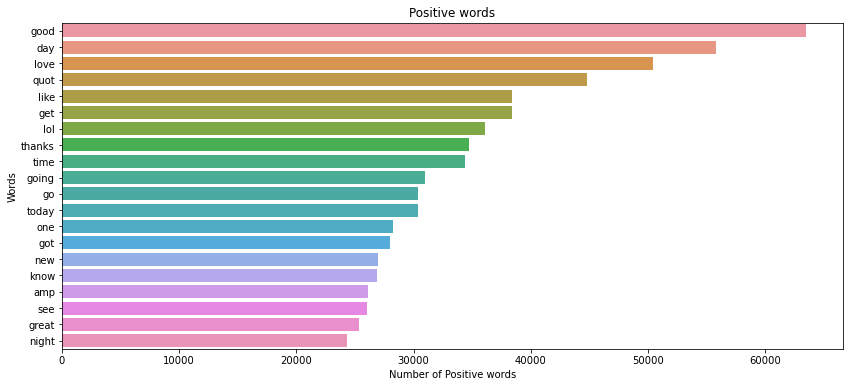

In [104]:
plt.subplots(figsize=(14,6))
sns.barplot(x=count,y=count.index)
plt.xlabel('Number of Positive words')
plt.ylabel('Words')
plt.title('Positive words')

In [79]:
Negative_words=dataset[dataset['sentiment']==0]['Processed_text']

In [105]:
neg_words=[]
for i in Negative_words:
    for j in i.strip().split(' '):
        if j not in ['good','get']:
            neg_words.append(j)
        

In [106]:
count_neg=pd.Series(neg_words).value_counts().head(20).sort_values(ascending=False)

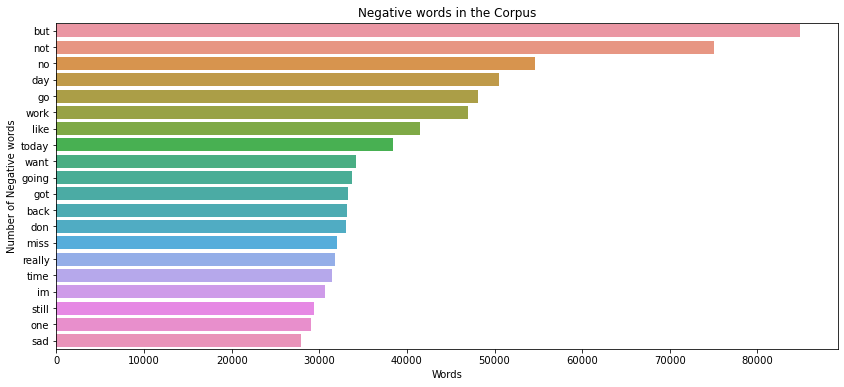

In [107]:
plt.subplots(figsize=(14,6))
sns.barplot(x=count_neg,y=count_neg.index)
plt.ylabel('Number of Negative words')
plt.xlabel('Words')
plt.title('Negative words in the Corpus')
plt.show()

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(Pos_words))
plt.imshow(wc)

# Splitting the data

In [91]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, dataset['sentiment'],test_size = 0.05, random_state = 0)
print('Data Split done')

Data Split done


In [93]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=50000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  50000


In [94]:
vectoriser

TfidfVectorizer(max_features=50000, ngram_range=(1, 2))

In [95]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


# Evaluating Models

In [96]:
def model_Evaluate(model,cv=False):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    
    print('Accuracy score',accuracy_score(y_test, y_pred))

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    class_report=classification_report(y_test, y_pred)
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    
    if cv==True:
        cross=cross_val_score(model,X_test,y_test,cv=4)
        print('The cross val score (4)',np.mean(cross))

Accuracy score 0.7882
              precision    recall  f1-score   support

           0       0.80      0.77      0.78     39989
           1       0.78      0.81      0.79     40011

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000

The cross val score (4) 0.76745


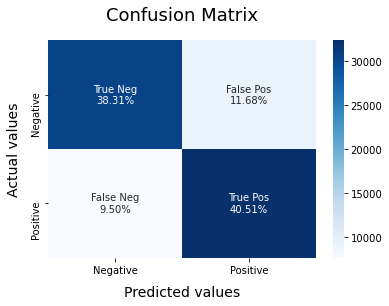

In [97]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel,cv=True)

In [ ]:
score_Card={}


Accuracy score 0.806025
              precision    recall  f1-score   support

           0       0.82      0.79      0.80     39989
           1       0.79      0.83      0.81     40011

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000

The cross val score (4) 0.7615000000000001


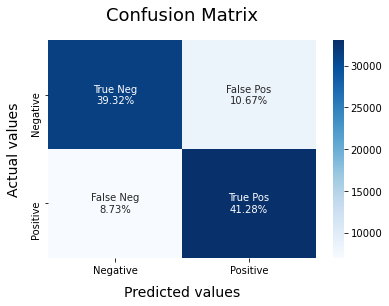

In [98]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel,cv=True)

Accuracy score 0.808375
              precision    recall  f1-score   support

           0       0.82      0.79      0.81     39989
           1       0.80      0.82      0.81     40011

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000

The cross val score (4) 0.7800999999999999


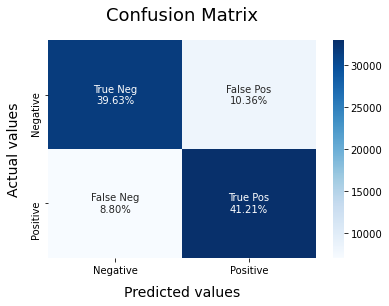

In [99]:
LRmodel = LogisticRegression(max_iter=1000)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel,cv=True)

In [192]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

In [ ]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    #df = df.replace([0,1], ["Neutral","Racist"])
    return df

if __name__=="__main__":
    # Loading the models.
    #vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    test_data=pd.read_csv('test_tweets_anuFYb8 (1).csv')
    
    text = test_data['tweet']
    
    
    df = predict(vectoriser,  , text)
    print(df.head())
    

In [15]:
!pip install wordcloud